In [1]:
import os

# %env XLA_FLAGS="--xla_force_host_platform_device_count=10"
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=10"
# os.environ["XLA_FLAGS"] = ('--xla_force_host_platform_device_count=10 '
                        #    '--xla_dump_to=xla_dump/')
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
# os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".95"

import arviz as az
import jax
# jax.config.update('jax_platform_name', 'cpu')
import jax.numpy as jnp
from jax import random
import seaborn as sns
from scipy.integrate import cumulative_trapezoid
import jax.numpy as jnp
from jax import random
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
from flax import linen as nn
import optax
import jax
import jax.numpy as jnp
from jax import random, jit, grad
import optax
from tqdm import tqdm
import matplotlib.pyplot as plt
# Assuming equivalent JAX implementations
from src.jax_subspace_curve import OrthoSpan, SubspaceModel
import numpyro
import numpyro.distributions as dist
from numpyro import handlers
import arviz as az
from src.jax_subspace_sampling import init_curve_frame_cp, ortho_at_one_t
from src.jax_subspace_curve import bezier_curve, pytree_to_matrix, vec_to_pytree
import pandas as pd
import wandb
import time
from jax_tqdm import scan_tqdm

from src.jax_test_model import MLPModel, MLPModelUCI, init_t_lambda_to_phi, init_model_tube, init_model_phi

from proba_sandbox.module_sandbox.dataset.tabular import TabularLoader
from proba_sandbox.module_sandbox.dataset.base import DataConfig

%load_ext autoreload
%autoreload 2
%env XLA_FLAGS

#jax.devices("gpu")

'--xla_force_host_platform_device_count=10'

In [2]:
def get_figsize(columnwidth, wf=0.5, hf=(5.**0.5-1.0)/2.0, ):
    """Parameters:
    - wf [float]:  width fraction in columnwidth units
    - hf [float]:  height fraction in columnwidth units.
                    Set by default to golden ratio.
    - columnwidth [float]: width of the column in latex. Get this from LaTeX 
                            using \showthe\columnwidth
    Returns:  [fig_width,fig_height]: that should be given to matplotlib
    """
    fig_width_pt = columnwidth*wf
    inches_per_pt = 1.0/72.27               # Convert pt to inch
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height = fig_width*hf      # height in inches
    return [fig_width, fig_height]


fig_width_pt = 234.8  # Get this from LaTeX using \showthe\columnwidth
inches_per_pt = 1.0/72.27               # Convert pt to inches
golden_mean = (np.sqrt(5)-1.0)/2.0         # Aesthetic ratio
fig_width = fig_width_pt*inches_per_pt  # width in inches
fig_height = fig_width*golden_mean       # height in inches
figsize = [fig_width, fig_height]
print("Figure size=", figsize)
tex_fonts = {
    # Use LaTeX to write all text
    "text.usetex": True,
    # "text.latex.preamble": r'\usepackage{amsfonts}',
    "font.family": "Nimbus Sans",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 9,
    "legend.title_fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "figure.figsize": figsize
}
plt.rcParams.update(tex_fonts)

Figure size= [3.2489276324892766, 2.0079477038671003]


### run all together and compute smootheness grid

In [10]:
# all functions from above
# get cuve params
def get_cp_w(run, from_path_optim_sweep=True):
    # load samples, data and curve params
    if from_path_optim_sweep:
        rrun_art  = run.logged_artifacts()  
    else:
        rrun_art = run.used_artifacts()
    for art in rrun_art:
        if art.type == "pytree":
            if from_path_optim_sweep:
                file = art.get_entry(f"{run.id}_params.npy").download(
                    root="./art_tmp")
            else:
                file = art.get_entry(f"{art.logged_by().id}_params.npy").download(
                    root="./art_tmp")
            params = jnp.load(file, allow_pickle=True).item()

            # define model
            # get design matrix from curve parameters stroed as pytree
            k = run.config['curve_params']['k']
            cp_w = pytree_to_matrix(params['params'], k)
            return params, cp_w


def get_data(run, from_path_optim_sweep=True):
    if from_path_optim_sweep:
        rrun_art  = run.logged_artifacts()  
    else:
        rrun_art = run.used_artifacts()
    # load samples, data and curve params
    for art in rrun_art:
        if art.type == "numpy":
            file_name = f"{run.config['rng_seed']}_{run.config['dataset']}_data.npz"
            file = art.get_entry(file_name).download(
                root="./art_tmp")
            with jnp.load(file, allow_pickle=True) as f:
                x = f['x']
                y = f['y']
                x_val = f['x_val']
                y_val = f['y_val']
                x_test = f['x_test']
                y_test = f['y_test']
            return x, y, x_val, y_val, x_test, y_test

def get_run(dataset, activation, k, seed, temp, space="lambda", s_sampling=True, prior_loddet=False, sweep_ids=['sf9qpgmf',], exp_name="my_name/subspace_uci"):
    api = wandb.Api()
    for s_id in sweep_ids:
        t_bar = tqdm(api.sweep(f"{exp_name}/{s_id}").runs)
        t_bar.set_description(f"Sweep id: {s_id}")
        for run in t_bar:
            if (run.config["dataset"] == dataset) and \
                (run.config['curve_params']['model_kwargs']["activation"] == activation) and \
                (run.config["curve_params"]['k'] == k) and \
                (run.config["curve_params"]['uniform_t_optimize'] == s_sampling) and \
                (run.config["rng_seed"] == seed) and \
                (run.config["sampling"]["space_config"].get("prior_correct", False) == prior_loddet) and \
                (run.config["sampling"]["space_config"]["space"] == space) and \
                (run.config['sampling']["temperature"] == temp):
                print(f"run found id: {run.id}")
                return run
            

def get_run_path(dataset, activation, k, seed, s_sampling=True, sweep_ids=['1qeujmhy',], exp_name="ddold/subspace_uci"):
    api = wandb.Api()
    for s_id in sweep_ids:
        t_bar = tqdm(api.sweep(f"{exp_name}/{s_id}").runs)
        t_bar.set_description(f"Sweep id: {s_id}")
        for run in t_bar:
            if (run.config["dataset"] == dataset) and \
                (run.config['curve_params']['model_kwargs']["activation"] == activation) and \
                (run.config["curve_params"]['k'] == k) and \
                (run.config["curve_params"]['uniform_t_optimize'] == s_sampling) and \
                (run.config["rng_seed"] == seed):
                print(f"run found id: {run.id}")
                return run


def set_model_data(model, x, y, scale, prior_correct):
    # if prior_correct == True:
    #     node_name = "logabsdet"
    # elif prior_correct == False:
    #     node_name = "t_scale"
    # else:
    #     node_name = None

    @jit
    def log_post_single(t, tube, temperature):
        cml = handlers.substitute(
            model, data={'t': t, 'tube': tube, 'scale': scale})
        ex_trace = handlers.trace(handlers.seed(cml, random.PRNGKey(0))
                                  ).get_trace(x, y, temperature)
        site = ex_trace['obs']
        log_like = site['fn'].log_prob(site['value']).sum(-1)
        log_like *= site['scale']
        # uniform speed scaling
        if prior_correct == "off":
            site = ex_trace['logabsdet']
            # to visualize the prior in varphi space
            logabsdet = -site['fn'].log_prob(site['value'])
        else:
            logabsdet = 0.  # in phi space prior is logabsdet - logabsdet = 0
        # prior
        site = ex_trace['t']
        prior = site['fn'].log_prob(site['value'])
        site = ex_trace['tube']
        prior += site['fn'].log_prob(site['value'])
        log_posterior = log_like + logabsdet + prior
        return log_posterior.squeeze(), ex_trace['varphi']['value']

    @jit
    def log_prior_single(t, tube):
        cml = handlers.substitute(
            model, data={'t': t, 'tube': tube, 'scale': scale})
        ex_trace = handlers.trace(handlers.seed(cml, random.PRNGKey(0))
                                  ).get_trace(x, y, 1.)
        site = ex_trace['t']
        prior = site['fn'].log_prob(site['value'])
        site = ex_trace['tube']
        prior += site['fn'].log_prob(site['value'])

        if prior_correct == "off":
            jax.debug.print("Hello off")
            site = ex_trace['logabsdet']
            logabsdet = -site['fn'].log_prob(site['value'])
        else:
            logabsdet = 0.  # in phi space prior is logabsdet - logabsdet = 0

        log_prior = logabsdet + prior
        return log_prior.squeeze(), ex_trace['varphi']['value']
    return log_post_single, log_prior_single

In [11]:
from src.plot import plot_subspace


def get_model_from_run(run):
    config = run.config
    k = config['curve_params']['k']
    model = MLPModelUCI(**config['curve_params']['model_kwargs'])

    params, cp_w = get_cp_w(run, from_path_optim_sweep=False)
    # initialize transformation functions
    t_phi_to_weight = OrthoSpan(cp_w)
    # control points in the varphi space
    cp_phi = t_phi_to_weight.inv(cp_w)
    t_lambda_to_phi, curve, d_bezier = init_t_lambda_to_phi(cp_phi, k,
                                                            epsilon=config['sampling']['space_config'].get(
                                                                'epsilon', 5.),
                                                            tube_scale=config['sampling']['space_config'].get('tube_scale', 1.))  # for phi space tube_scale is irelevant thus set to default

    tt = jnp.linspace(0., 1., 10_000)
    bezier_grad = jax.vmap(d_bezier)(tt)
    log_normalized_bezier_grad = jnp.log(jnp.trapezoid(
        jnp.linalg.norm(bezier_grad, axis=-1), tt))

    if run.config["sampling"]["space_config"]["space"] == 'lambda':
        sampling_model = init_model_tube(model,
                                    params['params'],
                                    k,
                                    t_lambda_to_phi,
                                    t_phi_to_weight,
                                    prior_scale=config['sampling']['space_config']['prior_scale'],
                                    prior_correct=config['sampling']['space_config']['prior_correct'],
                                    d_bezier=d_bezier,
                                    log_norm_d_bezier=log_normalized_bezier_grad,
                                    dist_scale="homo" if config['curve_params']['optimize_distparams'] else np.exp(
                                        params['dist_params']['log_scale'].item())
                                    )
    elif run.config["sampling"]["space_config"]["space"] == 'varphi':
        sampling_model = init_model_phi(model,
                                         params['params'],
                                         k,
                                         t_lambda_to_phi,
                                         prior_scale=config['sampling']['space_config']['prior_scale'],
                                         dist_scale="homo" if config['curve_params']['optimize_distparams'] else np.exp(
                                             params['dist_params']['log_scale'].item())
                                         )
    return sampling_model, config, params


def get_model_from_run_path(run):
    config = run.config
    k = config['curve_params']['k']
    model = MLPModelUCI(**config['curve_params']['model_kwargs'])

    params, cp_w = get_cp_w(run, from_path_optim_sweep=True)
    # initialize transformation functions
    t_phi_to_weight = OrthoSpan(cp_w)
    # control points in the varphi space
    cp_phi = t_phi_to_weight.inv(cp_w)
    t_lambda_to_phi, curve, d_bezier = init_t_lambda_to_phi(cp_phi, k,
                                                            epsilon=25,
                                                            tube_scale=0.1)

    tt = jnp.linspace(0., 1., 10_000)
    bezier_grad = jax.vmap(d_bezier)(tt)
    log_normalized_bezier_grad = jnp.log(jnp.trapezoid(
        jnp.linalg.norm(bezier_grad, axis=-1), tt))

    sampling_model = init_model_tube(model,
                                        params['params'],
                                        k,
                                        t_lambda_to_phi = t_lambda_to_phi,
                                        t_phi_to_weight = t_phi_to_weight,
                                        prior_scale=0.5,
                                        prior_correct=False,
                                        d_bezier=d_bezier,
                                        log_norm_d_bezier=log_normalized_bezier_grad,
                                        dist_scale=0.05
                                        )
    return sampling_model, config, params


def compute_grid(run, grid, prior=False, from_path_optim_sweep=True,
                 temperature=1.):
    if from_path_optim_sweep:
        model, config, params = get_model_from_run_path(run)
    else:
        model, config, params = get_model_from_run(run)
    k = config['curve_params']['k']
    x, y, x_val, y_val, x_test, y_test = get_data(run, from_path_optim_sweep=from_path_optim_sweep)

    X, Y = grid
    t_grid = X.flatten()

    log_post_single, log_prior_single = set_model_data(
        model, x, y,
        jnp.exp(params['dist_params']['log_scale']),
        prior_correct=None)
    log_single_fn = log_prior_single if prior else log_post_single
    log_post_save = []

    for i in range(k):
        t_orth_grid = jnp.zeros((t_grid.shape[0], k-1))
        t_orth_grid = t_orth_grid.at[:, i].set(Y.flatten())

        log_posterior = jax.vmap(log_single_fn, in_axes=(0, 0, None))(
            t_grid[:, None], t_orth_grid, temperature)
        log_post_save.append(jax.device_put(
            log_posterior, jax.devices('cpu')[0]))
    return log_post_save, config

Sweep id: igpgtr80:   0%|          | 0/125 [00:00<?, ?it/s]

Sweep id: igpgtr80:  21%|██        | 26/125 [00:00<00:00, 159.67it/s]


run found id: fvr9gyhh
space_at_t0 shape (20, 20)
Stores 40 orthogonal frames  
with ortho frame shape (40, 20, 20)


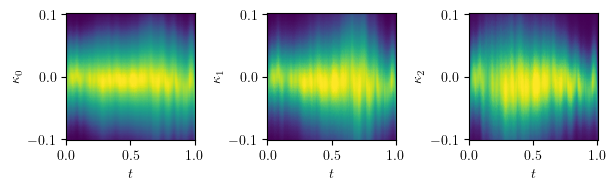

In [ ]:
run = get_run_path("yacht", "relu", k=20, seed=3, sweep_ids=['igpgtr80'])

tt = jnp.linspace(0.0, 1., 500)
t_ortho = jnp.linspace(-0.1, 0.1, 100)
X, Y = jnp.meshgrid(tt, t_ortho)

log_posterior_grid_relu, config = compute_grid(run, (X, Y))
show_k = min(config['curve_params']['k'], 3)

# fig, axs = plt.subplots(1, k-1, figsize=(figsize[0]*2, figsize[1]))
fig, axs = plt.subplots(1, show_k, figsize=(figsize[0]*2, figsize[1]))
if type(axs) == np.ndarray:
    axs = axs.ravel()
else:
    axs = [axs]
for i in range(show_k):
    ax = plot_subspace(X, Y, log_posterior_grid_relu[i][0].reshape(
        X.shape), label=r'$\propto p(\lambda|D)$', ax=axs[i], aspect_equal=False)
    axs[i].set_ylabel(rf'$\kappa_{i}$')
    axs[i].set_xlabel(r'$t$')

# remove colorbar
for ax in axs:
    fig.delaxes(fig.axes[-1])

plt.tight_layout()
plt.subplots_adjust(wspace=0.25)

space_at_t0 shape (20, 20)
Stores 40 orthogonal frames  
with ortho frame shape (40, 20, 20)


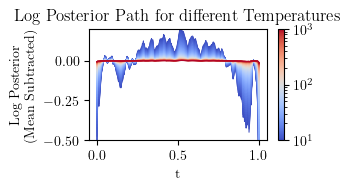

In [14]:
import matplotlib.colors as colors
temperature = np.logspace(1., 3., 100)[:, None, None]
tt = jnp.linspace(0.0, 1., 500)[:, None,]

sampling_model, config, params = get_model_from_run_path(run)

k = config['curve_params']['k']
tube = jnp.zeros(k-1)
x, y, x_val, y_val, x_test, y_test = get_data(run, from_path_optim_sweep=True)


log_post_single, log_prior_single = set_model_data(sampling_model, x, y,
                                 jnp.exp(params['dist_params']['log_scale']),
                                 prior_correct=None)
log_post_path, varphi = jax.vmap(jax.vmap(log_post_single, in_axes=(
    0, None, None)), in_axes=(None, None, 0))(tt, tube, temperature)

# Transform log_post_path into a pandas DataFrame
df = pd.DataFrame(log_post_path.reshape(-1,
                  log_post_path.shape[-1]), index=temperature.flatten())

# Transform the DataFrame into a tidy data format
df = pd.DataFrame(log_post_path)
df.columns = tt.flatten()
df['temperature'] = temperature.flatten()
df = df.melt(id_vars='temperature', var_name='t', value_name='log_post')

# Subtract the mean log posterior for each temperature
df['log_posterior'] = df.groupby('temperature')[
    'log_post'].transform(lambda x: x - x.mean())

# Plot the adjusted DataFrame using seaborn
fig, ax = plt.subplots(1, 1, figsize=figsize)
norm = colors.LogNorm(vmin=temperature.min(), vmax=temperature.max())
# sns.lineplot(data=df[df['temperature'] != 1.], x='t',
#              y='log_posterior', hue='temperature', palette="viridis", legend=False, ax=ax, hue_norm=norm, linewidth=0.5)

sns.lineplot(data=df, x='t',
             y='log_posterior', hue='temperature', palette="coolwarm", legend=False, ax=ax, hue_norm=norm, linewidth=0.75)
cbar = plt.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='coolwarm'), ax=ax)
plt.xlabel('t')
plt.ylabel('Log Posterior\n (Mean Subtracted)')
plt.title('Log Posterior Path for different Temperatures')
plt.tight_layout()
ax.set_ylim(-0.5, .2)
plt.savefig("figures/log_posterior_temperature_path_yacht_relu_20_3.pdf", bbox_inches='tight')


Sweep id: ttqplque:   0%|          | 0/40 [00:00<?, ?it/s]

Sweep id: ttqplque:  90%|█████████ | 36/40 [00:00<00:00, 835.36it/s]


run found id: k4agv95k
space_at_t0 shape (20, 20)
Stores 40 orthogonal frames  
with ortho frame shape (40, 20, 20)


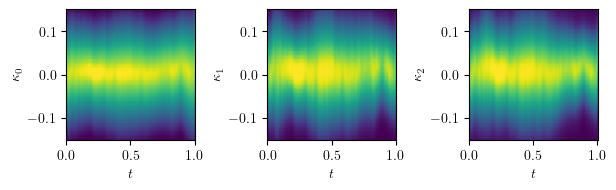

In [17]:
# run = get_run_path("airfoil", "relu", k=10, seed=1, sweep_ids=['1qeujmhy'])
# run = get_run_path("yacht", "elu", k=20, seed=1, sweep_ids=['ttqplque'])
setting = {'k': 20, 'seed': 1,}
run = get_run_path("yacht", "relu", k=setting['k'], seed=setting['seed'], sweep_ids=['ttqplque'])

tt = jnp.linspace(0.0, 1., 500)
ylim = 0.15
t_ortho = jnp.linspace(-ylim, ylim, 100)
X, Y = jnp.meshgrid(tt, t_ortho)

log_posterior_grid_relu, config = compute_grid(run, (X, Y), temperature=1)
vmin = log_posterior_grid_relu[0][0].min()
vmax = log_posterior_grid_relu[0][0].max()
show_k = min(config['curve_params']['k'], 3)

# fig, axs = plt.subplots(1, k-1, figsize=(figsize[0]*2, figsize[1]))
fig, axs = plt.subplots(1, show_k, figsize=(figsize[0]*2, figsize[1]))
if type(axs) == np.ndarray:
    axs = axs.ravel()
else:
    axs = [axs]
for i in range(show_k):
    ax = plot_subspace(X, Y, log_posterior_grid_relu[i][0].reshape(
        X.shape), label=r'$\propto p(\lambda|D)$', ax=axs[i], aspect_equal=False, vmax=vmax, vmin=vmin)
    axs[i].set_ylabel(rf'$\kappa_{i}$')
    axs[i].set_xlabel(r'$t$')

# remove colorbar
for ax in axs:
    fig.delaxes(fig.axes[-1])

plt.tight_layout()
plt.subplots_adjust(wspace=0.25)

Sweep id: ttqplque:   0%|          | 0/40 [00:00<?, ?it/s]

Sweep id: ttqplque:  78%|███████▊  | 31/40 [00:00<00:00, 656.78it/s]


run found id: byoxe7if
space_at_t0 shape (20, 20)
Stores 40 orthogonal frames  
with ortho frame shape (40, 20, 20)


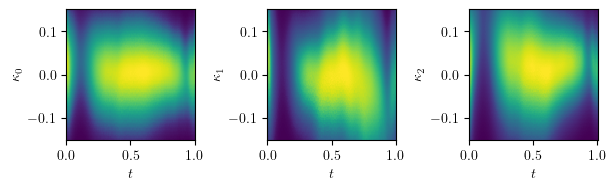

In [18]:
run = get_run_path(
    "yacht", "elu", k=setting['k'], seed=setting['seed'], sweep_ids=['ttqplque'])
# false comparision
# run = get_run_path(
#     "airfoil", "elu", k=setting['k'], seed=setting['seed'])
log_posterior_grid_elu, config = compute_grid(run, (X, Y))

vmax2 = log_posterior_grid_elu[0][0].max()
vmin2 = log_posterior_grid_elu[0][0].min()

# fig, axs = plt.subplots(1, k-1, figsize=(figsize[0]*2, figsize[1]))
fig, axs = plt.subplots(1, show_k, figsize=(figsize[0]*2, figsize[1]))
if type(axs) == np.ndarray:
    axs = axs.ravel()
else:
    axs = [axs]
for i in range(show_k):
    ax = plot_subspace(X, Y, log_posterior_grid_elu[i][0].reshape(
        X.shape), label=r'$\propto p(\lambda|D)$', ax=axs[i], aspect_equal=False, vmax=vmax2, vmin=vmin2)
    axs[i].set_ylabel(rf'$\kappa_{i}$')
    axs[i].set_xlabel(r'$t$')

# remove colorbar
for ax in axs:
    fig.delaxes(fig.axes[-1])

plt.tight_layout()
plt.subplots_adjust(wspace=0.25)

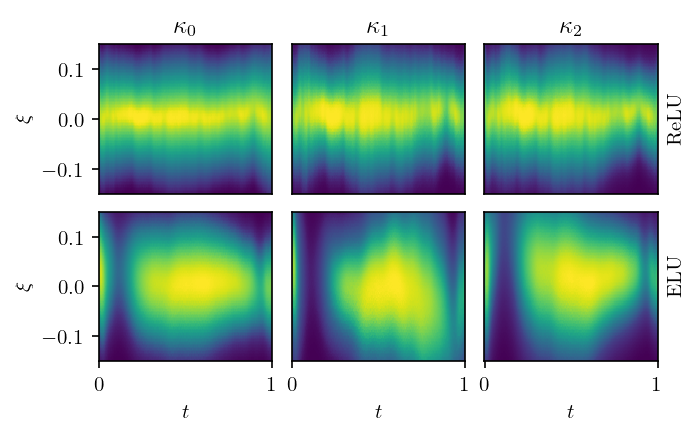

In [19]:
fig, axs = plt.subplots(2, 3, figsize=(figsize[0]*1.5, figsize[1]*1.5), dpi=150)
if type(axs) == np.ndarray:
    axs_ = axs.ravel()
else:
    axs_ = [axs]
for i in range(0, len(axs_)):
    if i < 3:
        log_posterior = log_posterior_grid_relu[i][0]
        ax = plot_subspace(X, Y, log_posterior.reshape(
            X.shape), label=r'$\propto p(\lambda|D)$', ax=axs_[i], aspect_equal=False, interpolate=False, vmax=vmax, vmin=vmin)
    else:
        log_posterior = log_posterior_grid_elu[i % 3][0]
        ax = plot_subspace(X, Y, log_posterior.reshape(
            X.shape), label=r'$\propto p(\lambda|D)$', ax=axs_[i], aspect_equal=False, interpolate=False, vmax=vmax, vmin=vmin)

    axs_[i].set_ylabel(rf'$\kappa_{i}$')
    axs_[i].set_xlabel(r'$t$')

# remove colorbar
for ax in axs_:
    fig.delaxes(fig.axes[-1])

for ax in axs[0][1:]:
    # ax.set_yticks([])
    ax.get_yaxis().set_visible(False)
for ax in axs[1][1:]:
    # ax.set_yticks([])
    ax.get_yaxis().set_visible(False)
    
for ax in axs:
    ax[0].set_yticks([-ylim+0.05, 0., ylim-0.05])


for ax in axs_:
    ax.set_ylim(-ylim, ylim)


for ax in axs[0]:
    ax.set_xlabel('')
    ax.set_xticks([])

axs[0][0].set_title(r'$\kappa_0$')
axs[0][1].set_title(r'$\kappa_1$')
axs[0][2].set_title(r'$\kappa_2$')

# axs[0][0].set_ylabel("ReLU \n" + r'$\kappa_0$')
axs[0][0].set_ylabel(r"$\xi$")
# axs[1][0].set_ylabel("ELU \n" + r'$\kappa_0$')
axs[1][0].set_ylabel(r"$\xi$")

plt.tight_layout()
plt.subplots_adjust(wspace=-0.11, hspace=0.12)
# fig.text(0.035, 0.54, r'$\leftarrow \xi \rightarrow$', ha='center',
#          va='center', rotation='vertical')
fig.text(0.935, 0.72, 'ReLU', ha='center',
         va='center', rotation='vertical')
fig.text(0.935, 0.37, 'ELU', ha='center',
         va='center', rotation='vertical')
# for ax in axs[1]:
#     # print(ax.xticks())
#     ax.xaxis.set_tick_params(right=True, pad=1)
    
plt.savefig("figures/subspace_smoothness_yacht.pdf", bbox_inches='tight')

### check sampling coverage

In [57]:
# all functions from above
# get cuve params
def get_cp_w(run, from_path_optim_sweep=True):
    # load samples, data and curve params
    if from_path_optim_sweep:
        rrun_art = run.logged_artifacts()
    else:
        rrun_art = run.used_artifacts()
    for art in rrun_art:
        if art.type == "pytree":
            if from_path_optim_sweep:
                file = art.get_entry(f"{run.id}_params.npy").download(
                    root="./art_tmp")
            else:
                file = art.get_entry(f"{art.logged_by().id}_params.npy").download(
                    root="./art_tmp")
            params = jnp.load(file, allow_pickle=True).item()

            # define model
            # get design matrix from curve parameters stroed as pytree
            k = run.config['curve_params']['k']
            cp_w = pytree_to_matrix(params['params'], k)
            return params, cp_w


def get_data(run, from_path_optim_sweep=True):
    if from_path_optim_sweep:
        rrun_art = run.logged_artifacts()
    else:
        rrun_art = run.used_artifacts()
    # load samples, data and curve params
    for art in rrun_art:
        if art.type == "numpy":
            file_name = f"{run.config['rng_seed']}_{run.config['dataset']}_data.npz"
            file = art.get_entry(file_name).download(
                root="./art_tmp")
            with jnp.load(file, allow_pickle=True) as f:
                x = f['x']
                y = f['y']
                x_val = f['x_val']
                y_val = f['y_val']
                x_test = f['x_test']
                y_test = f['y_test']
            return x, y, x_val, y_val, x_test, y_test

def get_run(dataset, activation, k, seed, temp, space="lambda", s_sampling=True, prior_loddet=False, sweep_ids=['sf9qpgmf',], exp_name="my_name/subspace_uci"):
    api = wandb.Api()
    for s_id in sweep_ids:
        t_bar = tqdm(api.sweep(f"{exp_name}/{s_id}").runs)
        t_bar.set_description(f"Sweep id: {s_id}")
        found_run = None
        for run in t_bar:
            if (run.config["dataset"] == dataset) and \
                (run.config['curve_params']['model_kwargs']["activation"] == activation) and \
                (run.config["curve_params"]['k'] == k) and \
                (run.config["curve_params"]['uniform_t_optimize'] == s_sampling) and \
                (run.config["rng_seed"] == seed) and \
                (run.config["sampling"]["space_config"].get("prior_correct", False) == prior_loddet) and \
                (run.config["sampling"]["space_config"]["space"] == space) and \
                    (run.config['sampling']["temperature"] == temp):
                print(f"run found id: {run.id}")
                found_run = run
                break
        if found_run is not None:
            return found_run
        else:
            raise Exception("No run found")


def get_run_path(dataset, activation, k, seed, s_sampling=True, sweep_ids=['1qeujmhy',], exp_name="my_name/subspace_uci"):
    api = wandb.Api()
    for s_id in sweep_ids:
        t_bar = tqdm(api.sweep(f"{exp_name}/{s_id}").runs)
        t_bar.set_description(f"Sweep id: {s_id}")
        for run in t_bar:
            if (run.config["dataset"] == dataset) and \
                (run.config['curve_params']['model_kwargs']["activation"] == activation) and \
                (run.config["curve_params"]['k'] == k) and \
                (run.config["curve_params"]['uniform_t_optimize'] == s_sampling) and \
                    (run.config["rng_seed"] == seed):
                print(f"run found id: {run.id}")
                return run


def get_model_from_run(run):
    config = run.config
    k = config['curve_params']['k']
    model = MLPModelUCI(**config['curve_params']['model_kwargs'])

    params, cp_w = get_cp_w(run, from_path_optim_sweep=False)
    # initialize transformation functions
    t_phi_to_weight = OrthoSpan(cp_w)
    # control points in the varphi space
    cp_phi = t_phi_to_weight.inv(cp_w)
    t_lambda_to_phi, curve, d_bezier = init_t_lambda_to_phi(cp_phi, k,
                                                            epsilon=config['sampling']['space_config'].get(
                                                                'epsilon', 5.),
                                                            tube_scale=config['sampling']['space_config'].get('tube_scale', 1.))  # for phi space tube_scale is irelevant thus set to default

    tt = jnp.linspace(0., 1., 10_000)
    bezier_grad = jax.vmap(d_bezier)(tt)
    log_normalized_bezier_grad = jnp.log(jnp.trapezoid(
        jnp.linalg.norm(bezier_grad, axis=-1), tt))

    if run.config["sampling"]["space_config"]["space"] == 'lambda':
        sampling_model = init_model_tube(model,
                                         params['params'],
                                         k,
                                         t_lambda_to_phi,
                                         t_phi_to_weight,
                                         prior_scale=config['sampling']['space_config']['prior_scale'],
                                         prior_correct=config['sampling']['space_config']['prior_correct'],
                                         d_bezier=d_bezier,
                                         log_norm_d_bezier=log_normalized_bezier_grad,
                                         dist_scale="homo" if config['curve_params']['optimize_distparams'] else np.exp(
                                             params['dist_params']['log_scale'].item())
                                         )
    elif run.config["sampling"]["space_config"]["space"] == 'varphi':
        sampling_model = init_model_phi(model,
                                        params['params'],
                                        k,
                                        t_phi_to_weight,
                                        prior_scale=config['sampling']['space_config']['prior_scale'],
                                        dist_scale="homo" if config['curve_params']['optimize_distparams'] else np.exp(
                                            params['dist_params']['log_scale'].item())
                                        )
    return sampling_model, config, params

def set_model_data(model, x, y, scale, prior_correct):
    # if prior_correct == True:
    #     node_name = "logabsdet"
    # elif prior_correct == False:
    #     node_name = "t_scale"
    # else:
    #     node_name = None

    @jit
    def log_post_single(t, tube, temperature):
        cml = handlers.substitute(
            model, data={'t': t, 'tube': tube, 'scale': scale})
        ex_trace = handlers.trace(handlers.seed(cml, random.PRNGKey(0))
                                  ).get_trace(x, y, temperature)
        site = ex_trace['obs']
        log_like = site['fn'].log_prob(site['value']).sum(-1)
        log_like *= site['scale']
        # uniform speed scaling
        if prior_correct == "off":
            site = ex_trace['logabsdet']
            logabsdet = -site['fn'].log_prob(site['value']) # to visualize the prior in varphi space
        else:
            logabsdet = 0.  # in phi space prior is logabsdet - logabsdet = 0
        # prior
        site = ex_trace['t']
        prior = site['fn'].log_prob(site['value'])
        site = ex_trace['tube']
        prior += site['fn'].log_prob(site['value'])
        log_posterior = log_like + logabsdet + prior
        return log_posterior.squeeze(), ex_trace['varphi']['value']

    @jit
    def log_prior_single(t, tube):
        cml = handlers.substitute(
            model, data={'t': t, 'tube': tube, 'scale': scale})
        ex_trace = handlers.trace(handlers.seed(cml, random.PRNGKey(0))
                                  ).get_trace(x, y, 1.)
        site = ex_trace['t']
        prior = site['fn'].log_prob(site['value'])
        site = ex_trace['tube']
        prior += site['fn'].log_prob(site['value'])

        if prior_correct == "off":
            jax.debug.print("Hello off")
            site = ex_trace['logabsdet']
            logabsdet = -site['fn'].log_prob(site['value'])
        else:
            logabsdet = 0. # in phi space prior is logabsdet - logabsdet = 0

        log_prior =  logabsdet + prior
        return log_prior.squeeze(), ex_trace['varphi']['value']
    return log_post_single, log_prior_single


def set_model_data_phi(model, x, y, scale):
    # if prior_correct == True:
    #     node_name = "logabsdet"
    # elif prior_correct == False:
    #     node_name = "t_scale"
    # else:
    #     node_name = None

    @jit
    def log_post_single(phi1, phi2, temperature):
        cml = handlers.substitute(
            model, data={'varphi': jnp.hstack([phi1, phi2]), 'scale': scale})
        ex_trace = handlers.trace(handlers.seed(cml, random.PRNGKey(0))
                                  ).get_trace(x, y, temperature)
        site = ex_trace['obs']
        log_like = site['fn'].log_prob(site['value']).sum(-1)
        log_like *= site['scale']
        # prior
        site = ex_trace['varphi']
        prior = site['fn'].log_prob(site['value'])
        log_posterior = log_like + prior
        return log_posterior.squeeze(), ex_trace['varphi']['value']

    @jit
    def log_prior_single(phi1, phi2,):
        cml = handlers.substitute(
            model, data={'varphi': jnp.hstack([phi1, phi2]), 'scale': scale})
        ex_trace = handlers.trace(handlers.seed(cml, random.PRNGKey(0))
                                  ).get_trace(x, y, 1.)
        site = ex_trace['varphi']
        prior = site['fn'].log_prob(site['value'])
        log_prior = prior
        return log_prior.squeeze(), ex_trace['varphi']['value']
    return log_post_single, log_prior_single

In [58]:
# settings = {'k': 2, 'seed': 1, 'temp': 1.}
# settings = {'k': 2, 'seed': 1, 'temp': 2.154}
# settings = {'k': 2, 'seed': 1, 'temp': 4.642}
# settings = {'k': 2, 'seed': 1, 'temp': 10}
# settings = {'k': 2, 'seed': 1, 'temp': 21.544}
settings = {'k': 2, 'seed': 1, 'temp': 46.416}
# settings = {'k': 2, 'seed': 1, 'temp': 100}
# settings = {'k': 2, 'seed': 1, 'temp': 215.443}
# settings = {'k': 2, 'seed': 1, 'temp': 464.159}

#### tunnel space with logabsdet correction 

Sweep id: sf9qpgmf:   0%|          | 0/135 [00:00<?, ?it/s]

Sweep id: sf9qpgmf:  70%|██████▉   | 94/135 [00:00<00:00, 579.71it/s]


run found id: 73og0xmm
space_at_t0 shape (2, 2)
Stores 6 orthogonal frames  
with ortho frame shape (6, 2, 2)


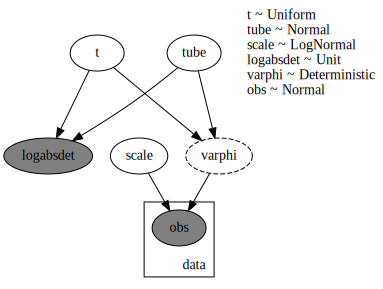

In [59]:
run = get_run("airfoil", "relu", k=settings['k'], seed=settings['seed'], temp=settings['temp'],
              space='lambda', prior_loddet=True, sweep_ids=['sf9qpgmf'])
model, config, params = get_model_from_run(run)


x, y, x_val, y_val, x_test, y_test = get_data(run, from_path_optim_sweep=False)

numpyro.render_model(model, (x, y), render_distributions=True)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

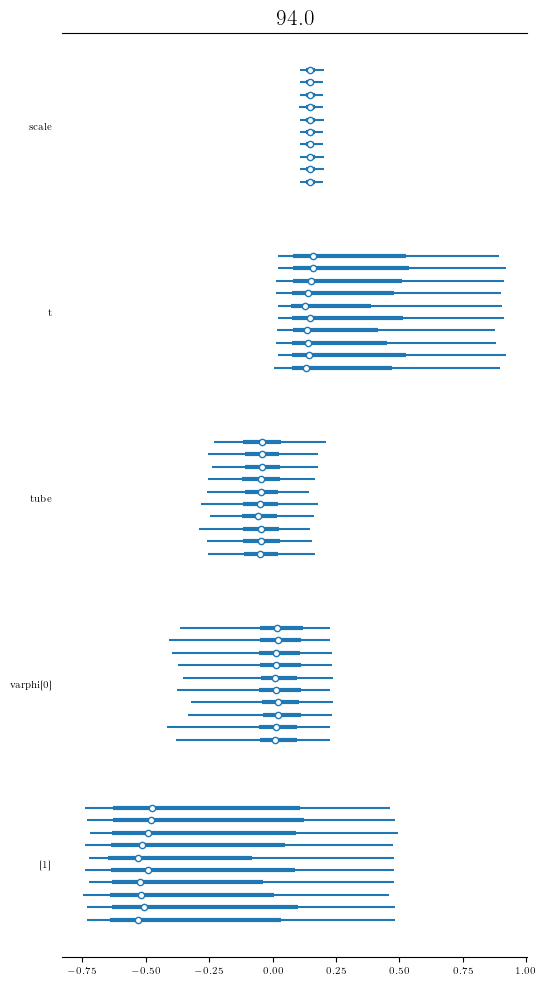

In [60]:
def get_samples_from_run(run):
    for art in run.logged_artifacts():
        if art.type == "xarray":
            file = art.get_entry(f"{run.id}_samples.nc").download(
                root="./art_tmp")
            samples = az.from_netcdf(file)
            return samples


posterior = get_samples_from_run(run)
az.plot_forest(posterior, combined=False)

In [61]:
log_post_fn, log_prior_fn = set_model_data(model, x, y, 
                                           jnp.exp(params['dist_params']['log_scale']),
                                           config["sampling"]["space_config"].get("prior_correct", False))

tt = jnp.linspace(-0.1, 1.1, 600)
t_ortho = jnp.linspace(-1., 1., 100)
X, Y = jnp.meshgrid(tt, t_ortho)

t_grid = X.flatten()
temperature = 1.

t_orth_grid = jnp.zeros((t_grid.shape[0], 1))
t_orth_grid = t_orth_grid.at[:, 0].set(Y.flatten())

log_prior = jax.vmap(log_prior_fn, in_axes=(0, 0))(
    t_grid[:, None], t_orth_grid)

log_post = jax.vmap(log_post_fn, in_axes=(0, 0, None))(
    t_grid[:, None], t_orth_grid, temperature)

log_prior, varphi = jax.device_put(log_prior, jax.devices('cpu')[0])
log_post, varphi_post = jax.device_put(log_post, jax.devices('cpu')[0])

log_prior.shape, varphi.shape

((60000,), (60000, 2))

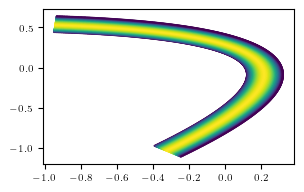

In [62]:
plt.scatter(varphi[:, 0], varphi[:,1], c=log_prior, s=0.1)

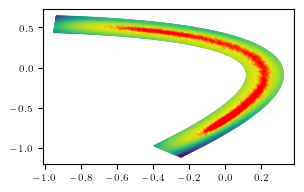

In [63]:
plt.scatter(varphi_post[:, 0], varphi_post[:, 1], c=log_post, s=0.1)
phi_samples = posterior.posterior['varphi'].values
phi_samples = phi_samples.reshape(-1, phi_samples.shape[-1])
plt.scatter(phi_samples[:, 0], phi_samples[:, 1],
            alpha=0.1, linewidths=0, s=3, c='red')
phi1_lim = plt.gca().get_xlim()
phi2_lim = plt.gca().get_ylim()

In [64]:
# save
os.makedirs("prior_coverage_plots", exist_ok=True)
with open("prior_coverage_plots/airfoil_s1_tunnel_sSample.npz", "wb") as f:
    np.savez(f, log_prob=log_prior, varphi=varphi,
             log_post=log_post, varphi_post=varphi_post, phi_samples=phi_samples)

#### tunnle space without logabsdet correction

Hello off
(60000,) (60000, 2)


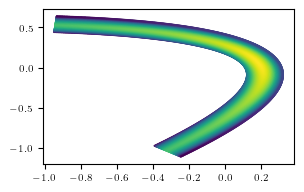

In [65]:
log_post_fn, log_prior_fn = set_model_data(model, x, y,
                                           jnp.exp(
                                               params['dist_params']['log_scale']),
                                           prior_correct="off")

log_prior = jax.vmap(log_prior_fn, in_axes=(0, 0))(
    t_grid[:, None], t_orth_grid)

log_prior, varphi = jax.device_put(log_prior, jax.devices('cpu')[0])

# os.makedirs("prior_coverage_plots", exist_ok=True)
# file_name = "prior_coverage_plots/airfoil_s1_prior_tSample.npz"
# with open(file_name + ".pkl", "wb") as f:
#     np.savez(f, log_prob=log_prior, varphi=varphi)
    
print(log_prior.shape, varphi.shape)
plt.scatter(varphi[:, 0], varphi[:, 1], c=log_prior, s=0.1)

In [66]:
import numpy as np
from scipy.integrate import trapezoid as trapz

# Compute the exponential of log_prior
exp_log_prior = np.exp(log_prior).reshape(X.shape)

# Reshape varphi to match the dimensions of exp_log_prior
varphi_x = varphi[:, 0].reshape(X.shape)
varphi_y = varphi[:, 1].reshape(Y.shape)

# Perform 2D trapezoidal integration
integral = trapz(trapz(exp_log_prior, varphi_x[0, :], axis=1), varphi_y[:, 0], axis=0)

print(f"2D Trapezoidal Integration Result: {integral}")

2D Trapezoidal Integration Result: 0.14856156706809998


#### volume space

Sweep id: sf9qpgmf:   0%|          | 0/135 [00:00<?, ?it/s]

Sweep id: sf9qpgmf:  63%|██████▎   | 85/135 [00:00<00:00, 248.76it/s]


run found id: 1fyrr5b5
space_at_t0 shape (2, 2)
Stores 3 orthogonal frames  
with ortho frame shape (3, 2, 2)


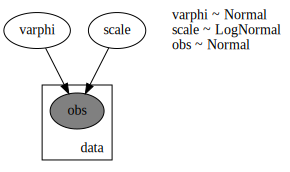

In [67]:
run = get_run("airfoil", "relu", k=settings['k'], seed=settings['seed'], temp=settings['temp'],
              space='varphi', prior_loddet=False, sweep_ids=['sf9qpgmf'])
model, config, params = get_model_from_run(run)


x, y, x_val, y_val, x_test, y_test = get_data(run, from_path_optim_sweep=False)

numpyro.render_model(model, (x, y), render_distributions=True)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

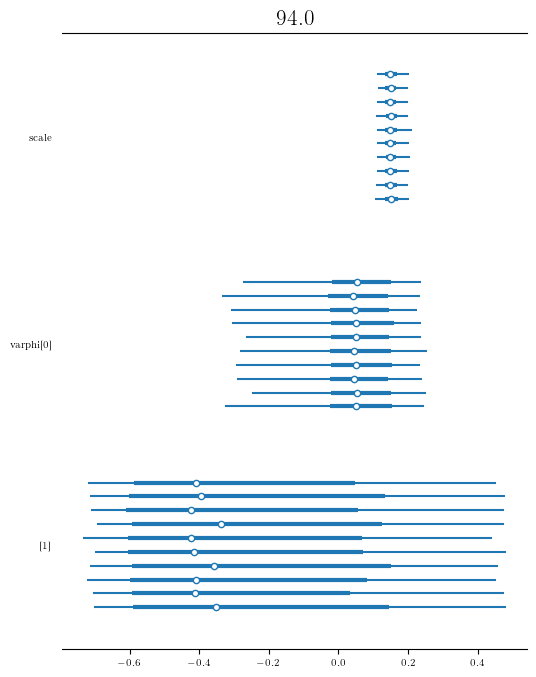

In [68]:
def get_samples_from_run(run):
    for art in run.logged_artifacts():
        if art.type == "xarray":
            file = art.get_entry(f"{run.id}_samples.nc").download(
                root="./art_tmp")
            samples = az.from_netcdf(file)
            return samples


posterior = get_samples_from_run(run)
az.plot_forest(posterior, combined=False)

In [69]:
log_post_fn, log_prior_fn = set_model_data_phi(model, x, y, 
                                               jnp.exp(params['dist_params']['log_scale']))

tt = jnp.linspace(*phi1_lim, 300)
t_ortho = jnp.linspace(*phi2_lim, 100)
X, Y = jnp.meshgrid(tt, t_ortho)

# t_grid = X.flatten()
temperature = 1.

# t_orth_grid = jnp.zeros((t_grid.shape[0], 1))
# t_orth_grid = t_orth_grid.at[:, 0].set(Y.flatten())

log_prior = jax.vmap(log_prior_fn, in_axes=(0, 0))(X.flatten(), Y.flatten())

log_post = jax.vmap(log_post_fn, in_axes=(0, 0, None))(
    X.flatten(), Y.flatten(), temperature)

log_prior, varphi = jax.device_put(log_prior, jax.devices('cpu')[0])
log_post, varphi_post = jax.device_put(log_post, jax.devices('cpu')[0])
log_prior.shape, varphi.shape

((30000,), (30000, 2))

(-1.19322310090065, 0.7281751453876495)

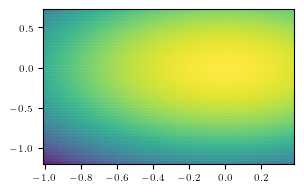

In [70]:
plt.scatter(varphi[:, 0], varphi[:,1], c=log_prior, s=0.1)
plt.gca().set_xlim(phi1_lim)
plt.gca().set_ylim(phi2_lim)

(-1.19322310090065, 0.7281751453876495)

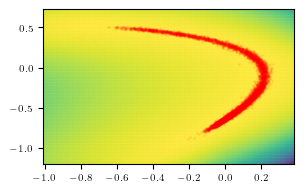

In [71]:
plt.scatter(varphi_post[:, 0], varphi_post[:, 1], c=log_post, s=0.1)
phi_samples = posterior.posterior['varphi'].values
phi_samples = phi_samples.reshape(-1, phi_samples.shape[-1])
plt.scatter(phi_samples[:, 0], phi_samples[:, 1],
            alpha=0.1, linewidths=0, s=3, c='red')

plt.gca().set_xlim(phi1_lim)
plt.gca().set_ylim(phi2_lim)

In [72]:
# save
file_name = "prior_coverage_plots/airfoil_s1_volume.npz"
with open(file_name, "wb") as f:
    np.savez(f, log_prob=log_prior, varphi=varphi,
             log_post=log_post, varphi_post=varphi_post, phi_samples=phi_samples)

#### create comparision

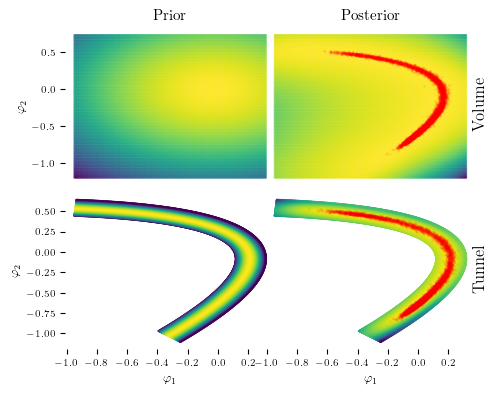

In [73]:
with open("prior_coverage_plots/airfoil_s1_volume.npz", "rb") as f:
    file = np.load(f, allow_pickle=True) 
    post_volume = file.get("log_post")
    prior_volume = file.get("log_prob")
    varphi_volume = file.get("varphi")
    varphi_post_volume = file.get("varphi_post")
    samples_volume = file.get("phi_samples")

with open("prior_coverage_plots/airfoil_s1_tunnel_sSample.npz", "rb") as f:
    file = np.load(f, allow_pickle=True)
    post_tunnel = file.get("log_post")
    prior_tunnel = file.get("log_prob")
    varphi_tunnel = file.get("varphi")
    varphi_post_tunnel = file.get("varphi_post")
    samples_tunnel = file.get("phi_samples")
    
fig, axes = plt.subplots(2, 2, figsize=(figsize[0]*1.5, figsize[1]*2))

# volume plot
# prior 
axes[0][0].scatter(varphi_volume[:, 0], varphi_volume[:, 1], c=prior_volume, s=0.1)
# posterior
axes[0][1].scatter(varphi_post_volume[:, 0], varphi_post_volume[:, 1],
                   c=post_volume, s=0.1)
axes[0][1].scatter(samples_volume[:, 0], samples_volume[:, 1],
            alpha=0.1, linewidths=0, s=3, c='red')

# tunnel plot
# prior
axes[1][0].scatter(varphi_tunnel[:, 0], varphi_tunnel[:, 1],
                   c=prior_tunnel, s=0.1)
# posterior
axes[1][1].scatter(varphi_post_tunnel[:, 0], varphi_post_tunnel[:, 1],
                   c=post_tunnel, s=0.1)
axes[1][1].scatter(samples_tunnel[:, 0], samples_tunnel[:, 1],
                   alpha=0.1, linewidths=0, s=3, c='red')
axes[0][0].set_title("Prior")
axes[0][1].set_title("Posterior")
axes[0][0].get_xaxis().set_visible(False)
axes[0][1].get_xaxis().set_visible(False)
axes[0][1].get_yaxis().set_visible(False)
axes[1][1].get_yaxis().set_visible(False)
axes[1][0].set_xlabel(r"$\varphi_1$")
axes[1][1].set_xlabel(r"$\varphi_1$")
axes[0][0].set_ylabel(r"$\varphi_2$")
axes[1][0].set_ylabel(r"$\varphi_2$")
for ax in axes.ravel():
    ax.set_frame_on(False)
plt.tight_layout()
plt.subplots_adjust(wspace=-0.05, hspace=0.05)
fig.text(.98, 0.73, 'Volume', ha='center',
         va='center', rotation='vertical', fontsize=12)
fig.text(0.98, 0.32, 'Tunnel', ha='center',
         va='center', rotation='vertical', fontsize=12)
plt.savefig(f"figures/prior_posterior_volume_tunnel_coverage_t{settings['temp']}.pdf", bbox_inches='tight')

#### run all compare

In [80]:
settings_all = [{'k': 2, 'seed': 1, 'temp': 1.}, 
                {'k': 2, 'seed': 1, 'temp': 2.154}, 
                {'k': 2, 'seed': 1, 'temp': 4.642}, 
                {'k': 2, 'seed': 1, 'temp': 10}, 
                {'k': 2, 'seed': 1, 'temp': 21.544}, 
                {'k': 2, 'seed': 1, 'temp': 46.416}, 
                {'k': 2, 'seed': 1, 'temp': 100}, 
                {'k': 2, 'seed': 1, 'temp': 215.443}, 
                {'k': 2, 'seed': 1, 'temp': 464.159}]


def get_samples_from_run(run):
    for art in run.logged_artifacts():
        if art.type == "xarray":
            file = art.get_entry(f"{run.id}_samples.nc").download(
                root="./art_tmp")
            samples = az.from_netcdf(file)
            return samples

os.makedirs("prior_coverage_plots", exist_ok=True)

for settings in settings_all:
    # run tunnel
    # model 
    run = get_run("airfoil", "relu", k=settings['k'], seed=settings['seed'], temp=settings['temp'],
                  space='lambda', prior_loddet=True, sweep_ids=['sf9qpgmf'])
    model, config, params = get_model_from_run(run)
    # data
    x, y, x_val, y_val, x_test, y_test = get_data(run, from_path_optim_sweep=False)
    posterior = get_samples_from_run(run)
    phi_samples = posterior.posterior['varphi'].values
    phi_samples = phi_samples.reshape(-1, phi_samples.shape[-1])

    log_post_fn, log_prior_fn = set_model_data(model, x, y,
                                               jnp.exp(
                                                   params['dist_params']['log_scale']),
                                               config["sampling"]["space_config"].get("prior_correct", False))

    # run grid
    tt = jnp.linspace(-0.1, 1.1, 300)
    t_ortho = jnp.linspace(-1., 1., 100)
    X, Y = jnp.meshgrid(tt, t_ortho)

    t_grid = X.flatten()
    temperature = 1.

    t_orth_grid = jnp.zeros((t_grid.shape[0], 1))
    t_orth_grid = t_orth_grid.at[:, 0].set(Y.flatten())

    log_prior = jax.vmap(log_prior_fn, in_axes=(0, 0))(
        t_grid[:, None], t_orth_grid)

    log_post = jax.vmap(log_post_fn, in_axes=(0, 0, None))(
        t_grid[:, None], t_orth_grid, temperature)

    log_prior, varphi = jax.device_put(log_prior, jax.devices('cpu')[0])
    log_post, varphi_post = jax.device_put(log_post, jax.devices('cpu')[0])

    with open(f"prior_coverage_plots/airfoil_s1_tunnel_sSample_t{settings['temp']}.npz", "wb") as f:
        np.savez(f, log_prob=log_prior, varphi=varphi,
                log_post=log_post, varphi_post=varphi_post, phi_samples=phi_samples)

    phi1_lim = varphi_post[:, 0].min()-0.05, varphi_post[:, 0].max()+0.05
    phi2_lim = varphi_post[:, 1].min()-0.05, varphi_post[:, 1].max()+0.05


    # run volume
    run = get_run("airfoil", "relu", k=settings['k'], seed=settings['seed'], temp=settings['temp'],
                  space='varphi', prior_loddet=False, sweep_ids=['sf9qpgmf'])
    model, config, params = get_model_from_run(run)
    x, y, x_val, y_val, x_test, y_test = get_data(run, from_path_optim_sweep=False)
    posterior = get_samples_from_run(run)
    phi_samples = posterior.posterior['varphi'].values
    phi_samples = phi_samples.reshape(-1, phi_samples.shape[-1])

    log_post_fn, log_prior_fn = set_model_data_phi(model, x, y,
                                                   jnp.exp(params['dist_params']['log_scale']))

    tt = jnp.linspace(*phi1_lim, 300)
    t_ortho = jnp.linspace(*phi2_lim, 100)
    X, Y = jnp.meshgrid(tt, t_ortho)

    # t_grid = X.flatten()
    temperature = 1.

    # t_orth_grid = jnp.zeros((t_grid.shape[0], 1))
    # t_orth_grid = t_orth_grid.at[:, 0].set(Y.flatten())

    log_prior = jax.vmap(log_prior_fn, in_axes=(0, 0))(X.flatten(), Y.flatten())

    log_post = jax.vmap(log_post_fn, in_axes=(0, 0, None))(
        X.flatten(), Y.flatten(), temperature)

    log_prior, varphi = jax.device_put(log_prior, jax.devices('cpu')[0])
    log_post, varphi_post = jax.device_put(log_post, jax.devices('cpu')[0])

    file_name = f"prior_coverage_plots/airfoil_s1_volume_t{settings['temp']}.npz"
    with open(file_name, "wb") as f:
        np.savez(f, log_prob=log_prior, varphi=varphi,
                log_post=log_post, varphi_post=varphi_post, phi_samples=phi_samples)

Sweep id: sf9qpgmf:   0%|          | 0/135 [00:00<?, ?it/s]

Sweep id: sf9qpgmf:  73%|███████▎  | 98/135 [00:00<00:00, 601.11it/s]


run found id: uefio9or
space_at_t0 shape (2, 2)
Stores 6 orthogonal frames  
with ortho frame shape (6, 2, 2)


Sweep id: sf9qpgmf:  67%|██████▋   | 90/135 [00:00<00:00, 536.28it/s]


run found id: percbn0c
space_at_t0 shape (2, 2)
Stores 3 orthogonal frames  
with ortho frame shape (3, 2, 2)


Sweep id: sf9qpgmf:  72%|███████▏  | 97/135 [00:00<00:00, 607.05it/s]


run found id: a5dyck11
space_at_t0 shape (2, 2)
Stores 6 orthogonal frames  
with ortho frame shape (6, 2, 2)


Sweep id: sf9qpgmf:  66%|██████▌   | 89/135 [00:00<00:00, 589.01it/s]


run found id: 5bcrelch
space_at_t0 shape (2, 2)
Stores 3 orthogonal frames  
with ortho frame shape (3, 2, 2)


Sweep id: sf9qpgmf:  38%|███▊      | 51/135 [00:00<00:00, 494.37it/s]


run found id: 6we7931r
space_at_t0 shape (2, 2)
Stores 6 orthogonal frames  
with ortho frame shape (6, 2, 2)


Sweep id: sf9qpgmf:  65%|██████▌   | 88/135 [00:00<00:00, 586.66it/s]


run found id: k25m5pgu
space_at_t0 shape (2, 2)
Stores 3 orthogonal frames  
with ortho frame shape (3, 2, 2)


Sweep id: sf9qpgmf:  71%|███████   | 96/135 [00:00<00:00, 582.88it/s]


run found id: vynh5msa
space_at_t0 shape (2, 2)
Stores 6 orthogonal frames  
with ortho frame shape (6, 2, 2)


Sweep id: sf9qpgmf:  64%|██████▍   | 87/135 [00:00<00:00, 565.97it/s]


run found id: t3jk0uj8
space_at_t0 shape (2, 2)
Stores 3 orthogonal frames  
with ortho frame shape (3, 2, 2)


Sweep id: sf9qpgmf:  70%|███████   | 95/135 [00:00<00:00, 572.04it/s]


run found id: zdmddwbe
space_at_t0 shape (2, 2)
Stores 6 orthogonal frames  
with ortho frame shape (6, 2, 2)


Sweep id: sf9qpgmf:  64%|██████▎   | 86/135 [00:00<00:00, 606.58it/s]


run found id: 69ls6t40
space_at_t0 shape (2, 2)
Stores 3 orthogonal frames  
with ortho frame shape (3, 2, 2)


Sweep id: sf9qpgmf:  70%|██████▉   | 94/135 [00:00<00:00, 232.61it/s]


run found id: 73og0xmm
space_at_t0 shape (2, 2)
Stores 6 orthogonal frames  
with ortho frame shape (6, 2, 2)


Sweep id: sf9qpgmf:  63%|██████▎   | 85/135 [00:00<00:00, 585.80it/s]


run found id: 1fyrr5b5
space_at_t0 shape (2, 2)
Stores 3 orthogonal frames  
with ortho frame shape (3, 2, 2)


Sweep id: sf9qpgmf:  69%|██████▉   | 93/135 [00:00<00:00, 572.62it/s]


run found id: qfi4dzs7
space_at_t0 shape (2, 2)
Stores 6 orthogonal frames  
with ortho frame shape (6, 2, 2)


Sweep id: sf9qpgmf:  62%|██████▏   | 84/135 [00:00<00:00, 573.97it/s]


run found id: uqqjtukn
space_at_t0 shape (2, 2)
Stores 3 orthogonal frames  
with ortho frame shape (3, 2, 2)


Sweep id: sf9qpgmf:  68%|██████▊   | 92/135 [00:00<00:00, 559.60it/s]


run found id: j82hd9ih
space_at_t0 shape (2, 2)
Stores 6 orthogonal frames  
with ortho frame shape (6, 2, 2)


Sweep id: sf9qpgmf:  61%|██████▏   | 83/135 [00:00<00:00, 566.35it/s]


run found id: i9coe40e
space_at_t0 shape (2, 2)
Stores 3 orthogonal frames  
with ortho frame shape (3, 2, 2)


Sweep id: sf9qpgmf:  67%|██████▋   | 91/135 [00:00<00:00, 222.08it/s]


run found id: mlb9kaxy
space_at_t0 shape (2, 2)
Stores 6 orthogonal frames  
with ortho frame shape (6, 2, 2)


Sweep id: sf9qpgmf:  61%|██████    | 82/135 [00:00<00:00, 564.14it/s]


run found id: rnsca48y
space_at_t0 shape (2, 2)
Stores 3 orthogonal frames  
with ortho frame shape (3, 2, 2)


In [81]:
os.makedirs("figures/prior_posterior_coverage", exist_ok=True)

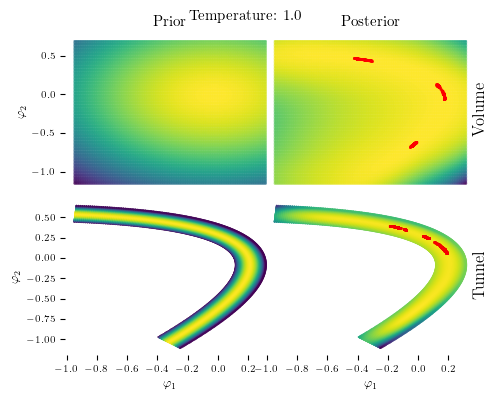

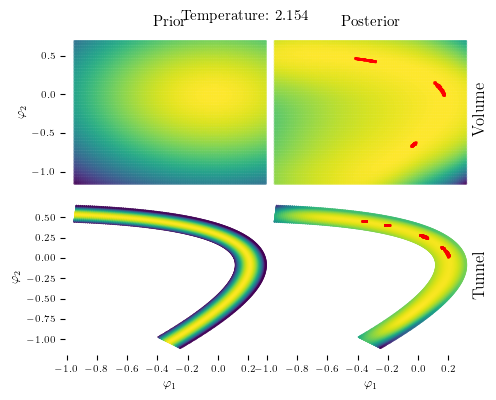

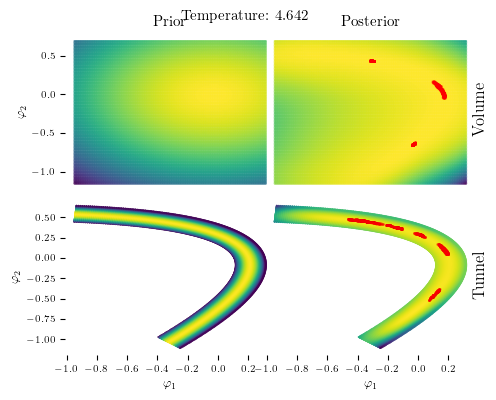

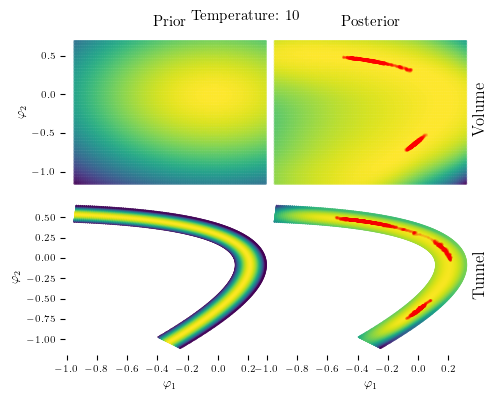

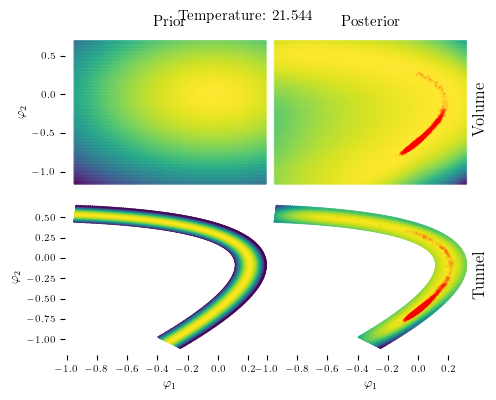

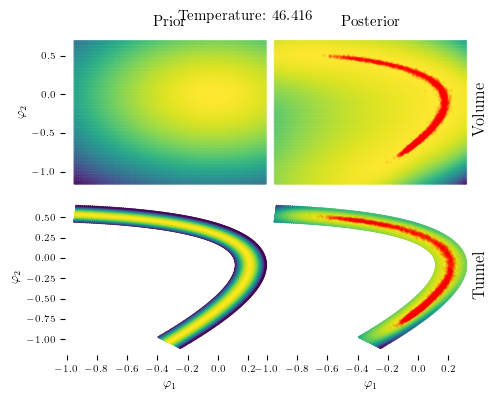

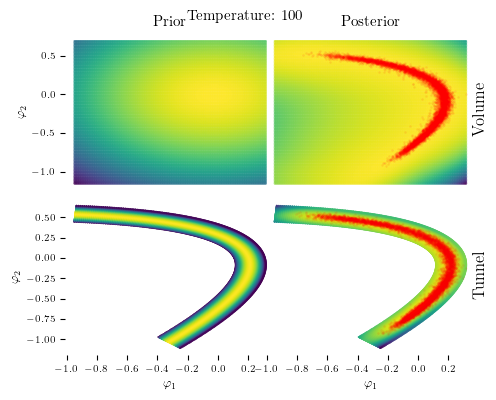

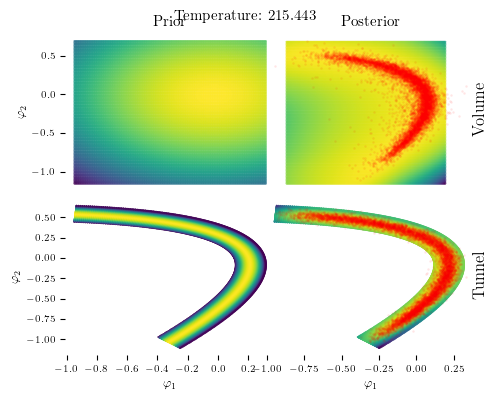

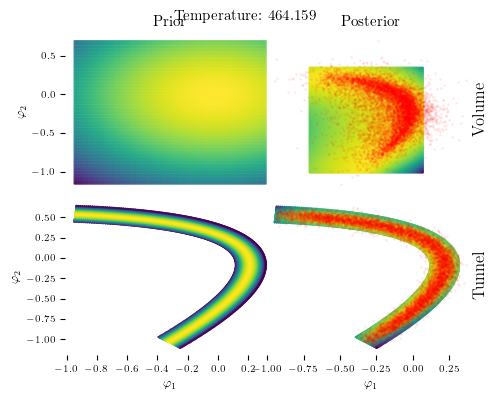

In [82]:
for settings in settings_all:
    with open(f"prior_coverage_plots/airfoil_s1_volume_t{settings['temp']}.npz", "rb") as f:
        file = np.load(f, allow_pickle=True)
        post_volume = file.get("log_post")
        prior_volume = file.get("log_prob")
        varphi_volume = file.get("varphi")
        varphi_post_volume = file.get("varphi_post")
        samples_volume = file.get("phi_samples")

    with open(f"prior_coverage_plots/airfoil_s1_tunnel_sSample_t{settings['temp']}.npz", "rb") as f:
        file = np.load(f, allow_pickle=True)
        post_tunnel = file.get("log_post")
        prior_tunnel = file.get("log_prob")
        varphi_tunnel = file.get("varphi")
        varphi_post_tunnel = file.get("varphi_post")
        samples_tunnel = file.get("phi_samples")

    fig, axes = plt.subplots(2, 2, figsize=(figsize[0]*1.5, figsize[1]*2))

    # volume plot
    # prior
    axes[0][0].scatter(varphi_volume[:, 0], varphi_volume[:, 1],
                    c=prior_volume, s=0.1)
    # posterior
    axes[0][1].scatter(varphi_post_volume[:, 0], varphi_post_volume[:, 1],
                    c=post_volume, s=0.1)
    axes[0][1].scatter(samples_volume[:, 0], samples_volume[:, 1],
                    alpha=0.1, linewidths=0, s=3, c='red')

    # tunnel plot
    # prior
    axes[1][0].scatter(varphi_tunnel[:, 0], varphi_tunnel[:, 1],
                    c=prior_tunnel, s=0.1)
    # posterior
    axes[1][1].scatter(varphi_post_tunnel[:, 0], varphi_post_tunnel[:, 1],
                    c=post_tunnel, s=0.1)
    axes[1][1].scatter(samples_tunnel[:, 0], samples_tunnel[:, 1],
                    alpha=0.1, linewidths=0, s=3, c='red')
    axes[0][0].set_title("Prior")
    axes[0][1].set_title("Posterior")
    axes[0][0].get_xaxis().set_visible(False)
    axes[0][1].get_xaxis().set_visible(False)
    axes[0][1].get_yaxis().set_visible(False)
    axes[1][1].get_yaxis().set_visible(False)
    axes[1][0].set_xlabel(r"$\varphi_1$")
    axes[1][1].set_xlabel(r"$\varphi_1$")
    axes[0][0].set_ylabel(r"$\varphi_2$")
    axes[1][0].set_ylabel(r"$\varphi_2$")
    for ax in axes.ravel():
        ax.set_frame_on(False)
    plt.tight_layout()
    plt.subplots_adjust(wspace=-0.05, hspace=0.05)
    fig.text(.98, 0.73, 'Volume', ha='center',
            va='center', rotation='vertical', fontsize=12)
    fig.text(0.98, 0.32, 'Tunnel', ha='center',
            va='center', rotation='vertical', fontsize=12)
    fig.suptitle(f"Temperature: {settings['temp']}")
    plt.savefig(
        f"figures/prior_posterior_coverage/prior_posterior_volume_tunnel_coverage_t{settings['temp']}.pdf", bbox_inches='tight')

### compare only prior difference

In [83]:
import datashader as ds
import pandas as pd
import datashader.transfer_functions as tf
import matplotlib.pyplot as plt

settings = {'k': 2, 'seed': 1, 'temp': 1.}

In [84]:
run = get_run("airfoil", "relu", k=settings['k'], seed=settings['seed'], temp=settings['temp'],
              space='lambda', prior_loddet=True, sweep_ids=['sf9qpgmf'])
model, config, params = get_model_from_run(run)
x, y, x_val, y_val, x_test, y_test = get_data(run, from_path_optim_sweep=False)

log_post_fn, log_prior_fn = set_model_data(model, x, y,
                                           jnp.exp(
                                               params['dist_params']['log_scale']),
                                           config["sampling"]["space_config"].get("prior_correct", False))

tt = jnp.linspace(-0.1, 1.1, 600)
t_ortho = jnp.linspace(-1., 1., 100)
X, Y = jnp.meshgrid(tt, t_ortho)

t_grid = X.flatten()
temperature = 1.

t_orth_grid = jnp.zeros((t_grid.shape[0], 1))
t_orth_grid = t_orth_grid.at[:, 0].set(Y.flatten())


log_prior = jax.vmap(log_prior_fn, in_axes=(0, 0))(
    t_grid[:, None], t_orth_grid)
log_prior_tunnel, varphi_tunnel = jax.device_put(log_prior, jax.devices('cpu')[0])

Sweep id: sf9qpgmf:   0%|          | 0/135 [00:00<?, ?it/s]

Sweep id: sf9qpgmf:  73%|███████▎  | 98/135 [00:00<00:00, 594.02it/s]


run found id: uefio9or
space_at_t0 shape (2, 2)
Stores 6 orthogonal frames  
with ortho frame shape (6, 2, 2)


In [85]:
log_post_fn, log_prior_fn = set_model_data(model, x, y,
                                           jnp.exp(
                                               params['dist_params']['log_scale']),
                                           prior_correct="off")

log_prior = jax.vmap(log_prior_fn, in_axes=(0, 0))(
    t_grid[:, None], t_orth_grid)

log_prior_tunnel_false, varphi_tunnel_false = jax.device_put(log_prior, jax.devices('cpu')[0])

Hello off


In [86]:
run = get_run("airfoil", "relu", k=settings['k'], seed=settings['seed'], temp=settings['temp'],
              space='varphi', sweep_ids=['sf9qpgmf'])
model, config, params = get_model_from_run(run)
x, y, x_val, y_val, x_test, y_test = get_data(run, from_path_optim_sweep=False)

log_post_fn, log_prior_fn = set_model_data_phi(model, x, y,
                                               jnp.exp(params['dist_params']['log_scale']))

x_lim = varphi_tunnel[:, 0].min().item(), varphi_tunnel[:, 0].max().item()
y_lim = varphi_tunnel[:, 1].min().item(), varphi_tunnel[:, 1].max().item()

tt = jnp.linspace(*x_lim, 300)
t_ortho = jnp.linspace(*y_lim, 300)
X, Y = jnp.meshgrid(tt, t_ortho)
t_grid = X.flatten()
temperature = 1.
t_orth_grid = jnp.zeros((t_grid.shape[0], 1))
t_orth_grid = t_orth_grid.at[:, 0].set(Y.flatten())

log_prior = jax.vmap(log_prior_fn, in_axes=(0, 0))(
    t_grid[:, None], t_orth_grid)
log_prior_volume, varphi_volume = jax.device_put(
    log_prior, jax.devices('cpu')[0])

Sweep id: sf9qpgmf:   0%|          | 0/135 [00:00<?, ?it/s]

Sweep id: sf9qpgmf:  67%|██████▋   | 90/135 [00:00<00:00, 562.19it/s]


run found id: percbn0c
space_at_t0 shape (2, 2)
Stores 3 orthogonal frames  
with ortho frame shape (3, 2, 2)


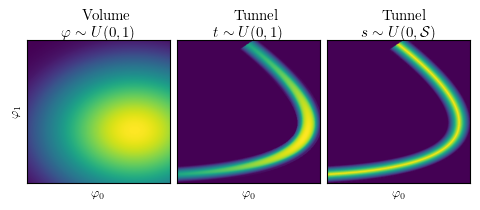

In [87]:

# Display the image using matplotlib
fig, axes = plt.subplots(1, 3, figsize=(figsize[0]*1.5, figsize[1]))
axes[0].imshow(img1.to_pil(), origin='lower')
axes[1].imshow(img2.to_pil(), origin='lower')
axes[2].imshow(img3.to_pil(), origin='lower')
axes[0].set_ylabel(r'$\varphi_1$')
for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
axes[0].set_xlabel(r'$\varphi_0$')
axes[1].set_xlabel(r'$\varphi_0$')
axes[2].set_xlabel(r'$\varphi_0$')
axes[0].set_title(r"Volume \\ $\varphi \sim U(0,1)$")
axes[1].set_title(r"Tunnel \\ $t\sim U(0,1)$")
axes[2].set_title(r"Tunnel \\ $s\sim U(0,\mathcal{S})$")
plt.tight_layout()
fig.subplots_adjust(wspace=0.05)
plt.savefig(f"figures/prior_compare.pdf", bbox_inches='tight')